In [3]:
"""These are assumed to be ran after the production database is updated"""

import pandas as pd

from mainnet_launch.database.postgres_operations import (
    _exec_sql_and_cache,
    get_full_table_as_df_with_tx_hash,
    get_full_table_as_df_with_block,
    ENGINE,
    get_full_table_as_df,
)
from mainnet_launch.database.schema.full import *

from mainnet_launch.slack_messages.post_message import post_slack_message, post_message_with_table


# add destination vault liquidations
# todo simply this to fewer sql queries
ENGINE.echo = True

In [ ]:
three_days_ago = pd.Timestamp.now() - pd.Timedelta(days=1)
claim_vault_rewards = get_full_table_as_df_with_tx_hash(ClaimVaultRewards, Blocks.datetime > three_days_ago)
destination_states = get_full_table_as_df_with_block(DestinationStates, Blocks.datetime > three_days_ago).reset_index()
autopool_destination_states = get_full_table_as_df_with_block(
    AutopoolDestinationStates, Blocks.datetime > three_days_ago
).reset_index()
destinations = get_full_table_as_df(Destinations)

claim_vault_rewards["pool"] = claim_vault_rewards["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
autopool_destination_states["pool"] = autopool_destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
destination_states["pool"] = destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)

destinations["incentive_apr"] = destinations["pool"].map(destination_states.groupby("pool")["incentive_apr"].max())
destinations["owned_shares"] = destinations["pool"].map(
    autopool_destination_states.groupby("pool")["owned_shares"].max()
)

taget_pool = "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"

# claim_vault_rewards = claim_vault_rewards[claim_vault_rewards['pool'] != taget_pool].copy()

# all claim events in the last 3 days
pool_with_recent_claim_rewards = claim_vault_rewards["pool"].unique().tolist()
# any autopool owns shares > 1 in the last 3 days
pools_with_some_owned_shares = (
    autopool_destination_states[autopool_destination_states["owned_shares"] > 1]["pool"].unique().tolist()
)
# >.5% apr within the last 3 days
pools_with_some_incentive_apr = (
    destination_states[destination_states["incentive_apr"] > 0.005]["pool"].unique().tolist()
)

2025-10-17 11:44:10,698 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-10-17 11:44:10,701 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-10-17 11:44:10,702 INFO sqlalchemy.engine.Engine [cached since 2519s ago] {'table_name': <sqlalchemy.sql.elements.TextClause object at 0x12df94f10>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-10-17 11:44:10,703 INFO sqlalchemy.engine.Engine 
            SELECT
                claim_vault_rewards.*,
                blocks.datetime,
                blocks.block
       

In [5]:
# taget_pool in pools_with_some_incentive_apr, taget_pool in pools_with_some_owned_shares, taget_pool in pool_with_recent_claim_rewards

expected = set(pools_with_some_incentive_apr) & set(pools_with_some_owned_shares)
missing = expected - set(pool_with_recent_claim_rewards)
missing

{'0x1DD4b13fcAE900C60a350589BE8052959D2Ed27B',
 '0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA',
 '0x616a4E1db48e22028f6bbf20444Cd3b8e3273738',
 '0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed',
 '0x7e97fa6893871A2751B5fE961978DCCb2c201E65',
 '0xD3Dc6b2c947F1BCa4D4a85114b34a71985606cd2',
 '0xc0c5689e6f4D256E861F65465b691aeEcC0dEb12',
 '0xc1256Ae5FF1cf2719D4937adb3bbCCab2E00A2Ca',
 '0xd9c4e277c93374a9f8C877a9D06707a88092E8F0',
 '0xeE8F4eC5672F09119b96Ab6fB59C27E1b7e44b61'}

In [7]:
destinations[destinations["pool"].isin(missing)]

,destination_vault_address,chain_id,exchange_name,name,symbol,pool_type,pool,underlying,underlying_symbol,underlying_name,denominated_in,destination_vault_decimals,incentive_apr,owned_shares
156,0x4eeDC6d6126ae9C6D92D03bB355eEAe5E47d2b03,8453,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0xeE8F4eC5672F09119b96Ab6fB59C27E1b7e44b61,0xeE8F4eC5672F09119b96Ab6fB59C27E1b7e44b61,gtUSDCp,Gauntlet USDC Prime,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.005686,5.409679e+06
157,0xFd70A9b4cE03Dc07Fe7Ba5e4D39fac11eE8d8615,8453,morpho,Tokemak-USD Coin-Moonwell Flagship USDC,toke-USDC-mwUSDC,metaMorpho,0xc1256Ae5FF1cf2719D4937adb3bbCCab2E00A2Ca,0xc1256Ae5FF1cf2719D4937adb3bbCCab2E00A2Ca,mwUSDC,Moonwell Flagship USDC,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.005686,4.909240e+05
164,0xCc68b840Bd7567363855e1e5050803EC7Ea8C25c,8453,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0xc0c5689e6f4D256E861F65465b691aeEcC0dEb12,0xc0c5689e6f4D256E861F65465b691aeEcC0dEb12,gtUSDCc,Gauntlet USDC Core,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.005686,9.135872e+05
168,0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7,8453,morpho,Tokemak-USD Coin-Seamless USDC Vault,toke-USDC-smUSDC,metaMorpho,0x616a4E1db48e22028f6bbf20444Cd3b8e3273738,0x616a4E1db48e22028f6bbf20444Cd3b8e3273738,smUSDC,Seamless USDC Vault,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.011700,8.403816e+06
194,0x310CCB9eC996A228cd6F4Eb2E70769ccDbeD163D,146,curve,Tokemak-Bridged USDC (Sonic Labs)-2Pool,toke-USDC.e-2CRV,curveNG,0xD3Dc6b2c947F1BCa4D4a85114b34a71985606cd2,0xD3Dc6b2c947F1BCa4D4a85114b34a71985606cd2,2CRV,2Pool,0x29219dd400f2Bf60E5a23d13Be72B486D4038894,18,0.073431,9.821959e+04
199,0xD7B1F55E0CcfFa849b35aA1c39B94eb415DB00cE,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,gtUSDCc,Gauntlet USDC Core,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.034215,3.397023e+06
201,0xAC8e9bbEFEAf5971c32E40b9b35DaD0B026a49fa,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,gtUSDCp,Gauntlet USDC Prime,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.017960,2.669634e+06
202,0x0F382528571b4A5C9196cEb706e5d15E38B57d81,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,gtUSDCc,Gauntlet USDC Core,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.034215,3.397023e+06
203,0xFf004bA7Df7F0D4fD0D1856f009184bd77A24192,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,gtUSDCp,Gauntlet USDC Prime,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.017960,2.669634e+06
216,0xab3DA8995D5FeA17913c3D12A5B199F1cCC9Bf0b,42161,morpho,Tokemak-USD Coin-Steakhouse High Yield USDC,toke-USDC-bbqUSDC,metaMorpho,0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA,0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA,bbqUSDC,Steakhouse High Yield USDC,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.051456,3.851299e+06


In [8]:
all_vault_claimed_events = get_full_table_as_df_with_tx_hash(ClaimVaultRewards)
all_vault_claimed_events["pool"] = all_vault_claimed_events["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
all_vault_claimed_events

2025-10-17 11:44:14,656 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-10-17 11:44:14,657 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-10-17 11:44:14,657 INFO sqlalchemy.engine.Engine [cached since 2523s ago] {'table_name': <sqlalchemy.sql.elements.TextClause object at 0x12dfbc700>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-10-17 11:44:14,658 INFO sqlalchemy.engine.Engine 
            SELECT
                claim_vault_rewards.*,
                blocks.datetime,
                blocks.block
       

,destination_vault_address,tx_hash,log_index,chain_id,token_address,amount_claimed,block,pool
datetime,,,,,,,,
2025-10-16 21:37:12+00:00,0xce1c8244410a4F97308Ffc5Ec926C9EF8FAeC809,0x6dbee4e6822d3fd55104e995f6d63faed8a2a2563577...,47,42161,0x1509706a6c66CA549ff0cB464de88231DDBe213B,4.288297e+18,390265621,0x19B001e6Bc2d89154c18e2216eec5C8c6047b6d8
2025-10-16 21:37:12+00:00,0xce1c8244410a4F97308Ffc5Ec926C9EF8FAeC809,0x6dbee4e6822d3fd55104e995f6d63faed8a2a2563577...,47,42161,0x040d1EdC9569d4Bab2D15287Dc5A4F10F56a56B8,2.384874e+18,390265621,0x19B001e6Bc2d89154c18e2216eec5C8c6047b6d8
2025-10-16 21:37:12+00:00,0xce1c8244410a4F97308Ffc5Ec926C9EF8FAeC809,0x6dbee4e6822d3fd55104e995f6d63faed8a2a2563577...,47,42161,0x7dfF72693f6A4149b17e7C6314655f6A9F7c8B33,4.962842e+19,390265621,0x19B001e6Bc2d89154c18e2216eec5C8c6047b6d8
2025-10-16 18:56:11+00:00,0x06993Ecd8d8a16204bf7f86B00A0575aB69548DD,0xfe1b8cdceef6b09abbfd0257129d5a03e5497f5bec92...,1160,8453,0x61E030A56D33e8260FdD81f03B162A79Fe3449Cd,3.375913e+19,36925812,0x1943FA26360f038230442525Cf1B9125b5DCB401
2025-10-16 18:55:55+00:00,0x071b90e1e322F5F94F74BA7ADd453BBE8D25032B,0xdb270d109f5ed78f9456dd86e5150e303430acb47f14...,694,8453,0x61E030A56D33e8260FdD81f03B162A79Fe3449Cd,1.218097e+20,36925804,0xf42f5795D9ac7e9D757dB633D693cD548Cfd9169
...,...,...,...,...,...,...,...,...
2024-09-18 15:25:59+00:00,0xE382BBd32C4E202185762eA433278f4ED9E6151E,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,316,1,0x4e3FBD56CD56c3e72c1403e103b45Db9da5B9D2B,1.620996e+18,20778361,0xC8Eb2Cf2f792F77AF0Cd9e203305a585E588179D
2024-09-18 15:25:59+00:00,0x6DcB6797b1C0442587c2ad79745ef7BB487Fc2E2,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,290,1,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,4.139774e+19,20778361,0xf01b0684C98CD7aDA480BFDF6e43876422fa1Fc1
2024-09-18 15:25:59+00:00,0x2F7e096a400ded5D02762120b39A3aA4ABA072a4,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,307,1,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,1.620302e+20,20778361,0x7761b6E0Daa04E70637D81f1Da7d186C205C2aDE


In [9]:
fluid_tether_pool = "0x5C20B550819128074FD538Edf79791733ccEdd18"
all_vault_claimed_events[all_vault_claimed_events["pool"] == fluid_tether_pool]

,destination_vault_address,tx_hash,log_index,chain_id,token_address,amount_claimed,block,pool
datetime,,,,,,,,
2025-05-17 23:10:11+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0x79320ebec65c7f4f4a4dde890a35060cf47132d7e032...,490,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,1.223330e+19,22505933,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-12 03:09:59+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0xa83bd308580390bf40de0dbf93e85559428d27267ad6...,454,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,1.397747e+19,22464448,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-10 23:10:11+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0xc446bb0a8bd1ab902b6b014649a40d4221087bb05066...,722,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,1.385031e+19,22456154,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-10 02:10:11+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0x18c28f87e0c29951e87e86055f7e2670dfa4b4fcca7b...,717,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,1.465057e+19,22449940,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-09 05:10:23+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0xd9722a816b279db519d5361ff9e01c757476ae864abd...,591,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,2.667618e+19,22443754,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-08 01:07:47+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0x3549a3c7fe3d5d6e3cf49e6cbac361d90592d44ca154...,290,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,4.678999e+19,22435464,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-06 21:13:59+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0x07600e82f2534d4d6797f111fcd3f650bb949b3a9d5e...,674,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,5.280921e+19,22427271,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-06 00:09:35+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0x2bdb970a34b7c0273a64b1a9c74ec26842e96c0af8f6...,394,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,5.953494e+19,22421014,0x5C20B550819128074FD538Edf79791733ccEdd18
2025-05-04 20:09:47+00:00,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,0x6147401a792f674fb22115d135d952d8a0877d06cb84...,440,1,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,6.706412e+19,22412684,0x5C20B550819128074FD538Edf79791733ccEdd18


In [10]:
destinations[destinations["pool"].isin(missing)][
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

,pool,exchange_name,underlying_name,chain_id,incentive_apr,owned_shares,destination_vault_address
156,0xeE8F4eC5672F09119b96Ab6fB59C27E1b7e44b61,morpho,Gauntlet USDC Prime,8453,0.005686,5.409679e+06,0x4eeDC6d6126ae9C6D92D03bB355eEAe5E47d2b03
157,0xc1256Ae5FF1cf2719D4937adb3bbCCab2E00A2Ca,morpho,Moonwell Flagship USDC,8453,0.005686,4.909240e+05,0xFd70A9b4cE03Dc07Fe7Ba5e4D39fac11eE8d8615
164,0xc0c5689e6f4D256E861F65465b691aeEcC0dEb12,morpho,Gauntlet USDC Core,8453,0.005686,9.135872e+05,0xCc68b840Bd7567363855e1e5050803EC7Ea8C25c
168,0x616a4E1db48e22028f6bbf20444Cd3b8e3273738,morpho,Seamless USDC Vault,8453,0.011700,8.403816e+06,0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7
194,0xD3Dc6b2c947F1BCa4D4a85114b34a71985606cd2,curve,2Pool,146,0.073431,9.821959e+04,0x310CCB9eC996A228cd6F4Eb2E70769ccDbeD163D
199,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,morpho,Gauntlet USDC Core,42161,0.034215,3.397023e+06,0xD7B1F55E0CcfFa849b35aA1c39B94eb415DB00cE
201,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,morpho,Gauntlet USDC Prime,42161,0.017960,2.669634e+06,0xAC8e9bbEFEAf5971c32E40b9b35DaD0B026a49fa
202,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,morpho,Gauntlet USDC Core,42161,0.034215,3.397023e+06,0x0F382528571b4A5C9196cEb706e5d15E38B57d81
203,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,morpho,Gauntlet USDC Prime,42161,0.017960,2.669634e+06,0xFf004bA7Df7F0D4fD0D1856f009184bd77A24192
216,0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA,morpho,Steakhouse High Yield USDC,42161,0.051456,3.851299e+06,0xab3DA8995D5FeA17913c3D12A5B199F1cCC9Bf0b


In [11]:
destinations[
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

,pool,exchange_name,underlying_name,chain_id,incentive_apr,owned_shares,destination_vault_address
0,0xa3931d71877C0E7a3148CB7Eb4463524FEc27fbD,none,Savings USDS,1,NaN,NaN,0xa767F35BF1d51f4ab7432188DfE6324934c9CCbD
1,0x0E80F6Db7fc8e5966828eaE36874B62dC8A47dc6,silo,Autopilot Wrapped - Apostro ETH Core,1,0.0,1.506979,0x6643834A8b4985514F83101597e2dCd2ae3b0ce7
2,0x57c23c58B1D8C3292c15BEcF07c62C5c52457A42,balancerV3,Balancer osETH-waWETH,1,NaN,NaN,0x4142e3a17391676C66DDf1285E43889F168EE237
3,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,curve,pxETH/stETH,1,NaN,NaN,0xB84c580c005A5F633C8CF6eecAf5b0a8314EC5c4
4,0xb45ad160634c528Cc3D2926d9807104FA3157305,inverse,Staked Dola,1,NaN,NaN,0x116b3e86f2b04c21605c5fC4b95Ba6A82dBF8F3E
...,...,...,...,...,...,...,...
230,0xA31C7dDAD8F1D66D037C4EE76F8fb725f927Bc25,aave,Wrapped Aave Plasma sUSDe,9745,0.0,0.000000,0x5DFFAE9a249db6fc61906BaE2c1e640045602ee7
231,0xE0126F0c4451B2B917064A93040fd4770D6774b5,aave,Wrapped Aave Plasma USDT0,9745,0.0,0.000000,0xdE4D6c5416ff7584373020fa24F160d193F84855
232,0x4718484ac9dc07fbbC078561e8f8Ef29e2a369CD,euler,EVK Vault eUSDT0-9,9745,0.0,0.000000,0xF3dE68350bf01d90FE9eD09A20B20E984E78d217
233,0x64273624eb57c5cA961d366CBF3968e760Bf0452,curve,DOLA/wstUSR,1,NaN,NaN,0x3DB1fe3B1839798aA22fA0143D326D3693728915


In [12]:
# usdc Fluid Tether USD should have some incentive apr


# 0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb autoUSD has 750k in this pool

In [13]:
# # is there a way to manually check if rewards are claimable? a function call?
# post_message_with_table(
#     "Pools with incentives and owned shares but no recent claims",
#     destinations[destinations['pool'].isin(missing)][['pool', 'exchange_name', 'chain_id', 'incentive_apr', 'owned_shares']]
# )

In [14]:
destinations[destinations["pool"].isin(missing)]

,destination_vault_address,chain_id,exchange_name,name,symbol,pool_type,pool,underlying,underlying_symbol,underlying_name,denominated_in,destination_vault_decimals,incentive_apr,owned_shares
156,0x4eeDC6d6126ae9C6D92D03bB355eEAe5E47d2b03,8453,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0xeE8F4eC5672F09119b96Ab6fB59C27E1b7e44b61,0xeE8F4eC5672F09119b96Ab6fB59C27E1b7e44b61,gtUSDCp,Gauntlet USDC Prime,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.005686,5.409679e+06
157,0xFd70A9b4cE03Dc07Fe7Ba5e4D39fac11eE8d8615,8453,morpho,Tokemak-USD Coin-Moonwell Flagship USDC,toke-USDC-mwUSDC,metaMorpho,0xc1256Ae5FF1cf2719D4937adb3bbCCab2E00A2Ca,0xc1256Ae5FF1cf2719D4937adb3bbCCab2E00A2Ca,mwUSDC,Moonwell Flagship USDC,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.005686,4.909240e+05
164,0xCc68b840Bd7567363855e1e5050803EC7Ea8C25c,8453,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0xc0c5689e6f4D256E861F65465b691aeEcC0dEb12,0xc0c5689e6f4D256E861F65465b691aeEcC0dEb12,gtUSDCc,Gauntlet USDC Core,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.005686,9.135872e+05
168,0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7,8453,morpho,Tokemak-USD Coin-Seamless USDC Vault,toke-USDC-smUSDC,metaMorpho,0x616a4E1db48e22028f6bbf20444Cd3b8e3273738,0x616a4E1db48e22028f6bbf20444Cd3b8e3273738,smUSDC,Seamless USDC Vault,0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913,18,0.011700,8.403816e+06
194,0x310CCB9eC996A228cd6F4Eb2E70769ccDbeD163D,146,curve,Tokemak-Bridged USDC (Sonic Labs)-2Pool,toke-USDC.e-2CRV,curveNG,0xD3Dc6b2c947F1BCa4D4a85114b34a71985606cd2,0xD3Dc6b2c947F1BCa4D4a85114b34a71985606cd2,2CRV,2Pool,0x29219dd400f2Bf60E5a23d13Be72B486D4038894,18,0.073431,9.821959e+04
199,0xD7B1F55E0CcfFa849b35aA1c39B94eb415DB00cE,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,gtUSDCc,Gauntlet USDC Core,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.034215,3.397023e+06
201,0xAC8e9bbEFEAf5971c32E40b9b35DaD0B026a49fa,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,gtUSDCp,Gauntlet USDC Prime,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.017960,2.669634e+06
202,0x0F382528571b4A5C9196cEb706e5d15E38B57d81,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Core,toke-USDC-gtUSDCc,metaMorpho,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,0x7e97fa6893871A2751B5fE961978DCCb2c201E65,gtUSDCc,Gauntlet USDC Core,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.034215,3.397023e+06
203,0xFf004bA7Df7F0D4fD0D1856f009184bd77A24192,42161,morpho,Tokemak-USD Coin-Gauntlet USDC Prime,toke-USDC-gtUSDCp,metaMorpho,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,0x7c574174DA4b2be3f705c6244B4BfA0815a8B3Ed,gtUSDCp,Gauntlet USDC Prime,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.017960,2.669634e+06
216,0xab3DA8995D5FeA17913c3D12A5B199F1cCC9Bf0b,42161,morpho,Tokemak-USD Coin-Steakhouse High Yield USDC,toke-USDC-bbqUSDC,metaMorpho,0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA,0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA,bbqUSDC,Steakhouse High Yield USDC,0xaf88d065e77c8cC2239327C5EDb3A432268e5831,18,0.051456,3.851299e+06


In [15]:
destinations[destinations["pool"] == "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"]  # there are 4 destiantions here,

,destination_vault_address,chain_id,exchange_name,name,symbol,pool_type,pool,underlying,underlying_symbol,underlying_name,denominated_in,destination_vault_decimals,incentive_apr,owned_shares
3,0xB84c580c005A5F633C8CF6eecAf5b0a8314EC5c4,1,curve,Tokemak-Wrapped Ether-pxETH/stETH,toke-WETH-pxsteth,curveNG,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,pxsteth,pxETH/stETH,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,18,NaN,NaN
37,0xe4433D00Cf48BFE0C672d9949F2cd2c008bffC04,1,curve,Tokemak-Wrapped Ether-pxETH/stETH,toke-WETH-pxsteth,curveNG,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,pxsteth,pxETH/stETH,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,18,NaN,NaN
42,0x2E0E2AB6505A1182367DFB1e3c66648bF3EEA020,1,curve,Tokemak-Wrapped Ether-pxETH/stETH,toke-WETH-pxsteth,curveNG,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,pxsteth,pxETH/stETH,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,18,NaN,NaN
56,0xd96E943098B2AE81155e98D7DC8BeaB34C539f01,1,curve,Tokemak-Wrapped Ether-pxETH/stETH,toke-WETH-pxsteth,curveNG,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,pxsteth,pxETH/stETH,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,18,NaN,NaN


In [16]:
# 0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6 had incentive APR go to zero on oct 14th

# need to not point at old destination vaults
# have the agg entity by the pool it self

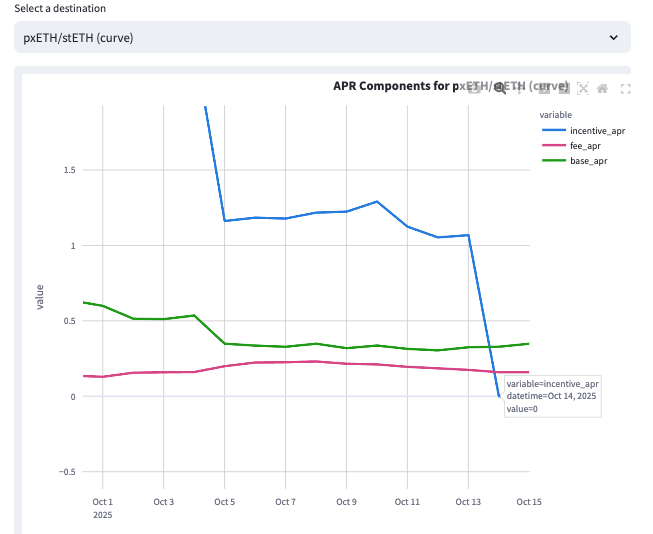

In [17]:
# can I manually check if rewards are claimable?

In [18]:
didnt_have_expected_liquidation

NameError: name 'didnt_have_expected_liquidation' is not defined

In [ ]:
destinations[destinations["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
destination_states[destination_states["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
owned_shares_by_destination = (
    autopool_destination_states[["destination_vault_address", "owned_shares"]]
    .groupby("destination_vault_address")
    .max()
    .reset_index()
)

In [ ]:
def get_list_of_suspect_destinations():
    # a suspect_destination is a destiantion
    # where, the owned shares in the last 3 days is > 1
    # and the incentive apr is > .5
    # and there have been no claim vault rewards in the last 3 days
    pass